# Exploratory Data Analysis

Importing libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples, adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import entropy
from plotly.subplots import make_subplots
from umap import UMAP
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

Reading files

In [70]:
# Clase contains which type of tissue is each
X = pd.read_csv('datasets/dataset_tissue.txt', index_col = 0).T
y = pd.read_csv('datasets/clase.txt', index_col = 0)

There is no need of using pipelines in this case, so it is scaled the data as first step

In [71]:
X_sc = MinMaxScaler().fit_transform(X)

It has to be known the appropiate number of components which are employed to perform SVD algorythm

In [72]:
# declaring and SVD instance
svd_all = TruncatedSVD(n_components = X.shape[0], random_state = 23)

# fitting pipeline
svd_all.fit(X_sc)

TruncatedSVD(n_components=189, random_state=23)

Plotting cumulative variance ratio

Number of components: 61


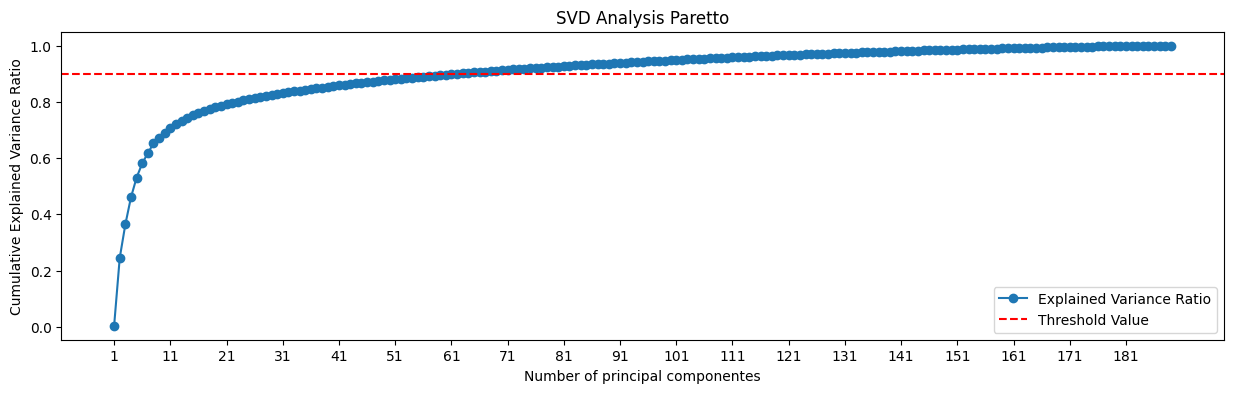

In [73]:
# getting cumulative variance
cum_variance = np.cumsum(svd_all.explained_variance_ratio_)

# choosing threshold
threshold = 0.90

# Calculating the selected number of components by using the chosen threshold
n_svd = len(cum_variance[cum_variance <= threshold])
print(f"Number of components: {n_svd}")

# defining plot
plt.figure(figsize = (15, 4))
plt.plot(cum_variance, '-o', label = 'Explained Variance Ratio')
plt.title('SVD Analysis Paretto')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xlabel('Number of principal componentes')
plt.xticks(range(0, X.shape[0], 10), range(1, X.shape[0] + 1, 10))
plt.axhline(threshold, c = 'red', label = 'Threshold Value', linestyle = '--')
plt.legend()
plt.show()


Then the new X dataset is fitted by using the found n_components, but it is used UMAP as de reducer based ond the svd's number of components

In [74]:
# declaring and umap instance
umap = UMAP(n_components = n_svd, n_neighbors = 7,init = 'random', random_state = 23)

# fitting model
X_umap = umap.fit_transform(X_sc)

Cleaning outliers

In [75]:
# function to replace outliers
def clean_outliers(array, col):
    q1 = np.percentile(array[:, col], 25)
    q3 = np.percentile(array[:, col], 75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    array[:, col] = np.select([array[:, col] > upper_bound, array[:, col] < lower_bound],
                              [upper_bound, lower_bound],
                              default = array[:, col])
    return array

length = X_umap.shape[1]
for column in range(length):
    X_umap = clean_outliers(X_umap, column)

Applying Agglomerative Hierarchical Clustering on those selected principal components

In [76]:
# declaring hierarchical clustering instance
agg_clus = AgglomerativeClustering(n_clusters = None, distance_threshold = 0)

# fitting model
agg_clus.fit(X_umap)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Defining function to plot dendrogram

In [77]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

Plotting dendrogram

Number of Unique Variables of each type: 7


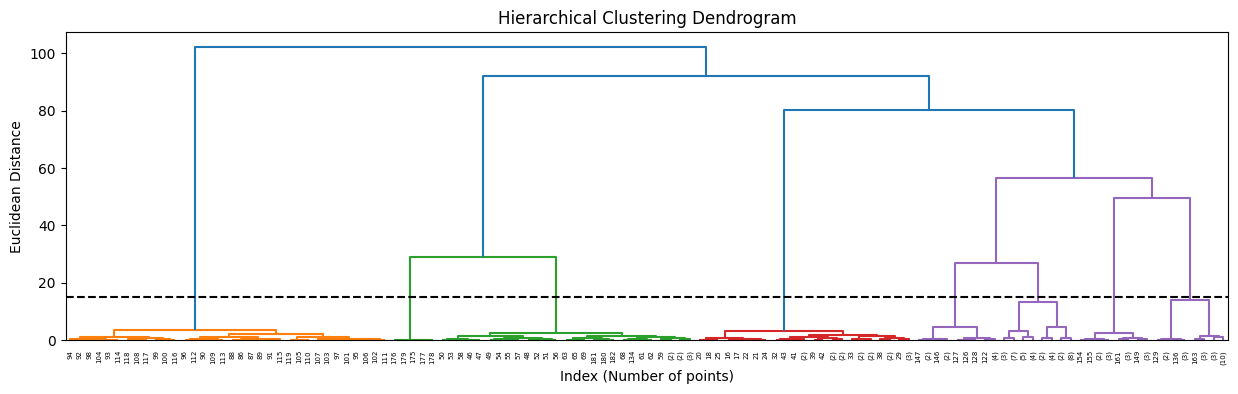

In [78]:
# defining plot
threshold_line_cut = 15
plt.figure(figsize = (15, 4))
top_n_levels_dendrogram = len(np.unique(y))
print(f"Number of Unique Variables of each type: {top_n_levels_dendrogram}")
plot_dendrogram(agg_clus, truncate_mode = 'level', p = top_n_levels_dendrogram)
plt.axhline(threshold_line_cut, c = 'black', linestyle = '--')
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Euclidean Distance')
plt.xlabel('Index (Number of points)')
plt.show()

It can be seen in the previous Figure, by cutting the Hierarchical Dendrogram at 15 Euclidian Distance, it is obtained 6 clusters which corresponds to the number of unique variable of "y" dataset minus one. Now, three unsupervised algorithms will be trained.

# KMeans

Selecting proper number of cluster by a first approach: inertias

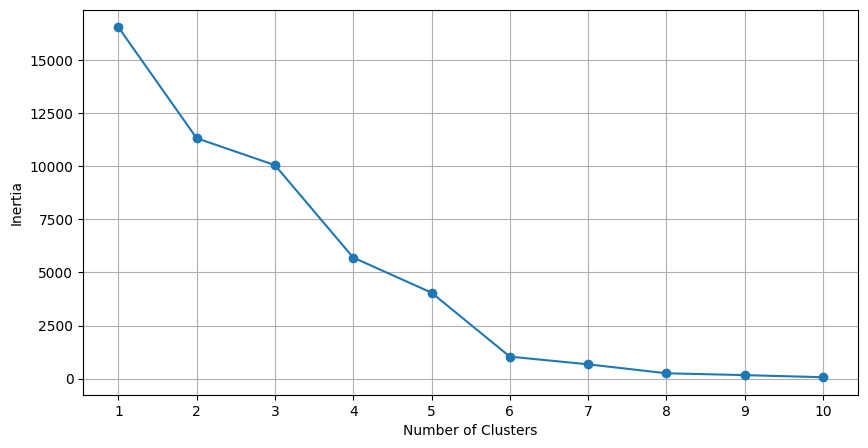

In [79]:
means = []
inertias = []
max_k = 10 # max number of cluster to be tested

for k in range(1, max_k + 1):

    kmeans = KMeans(n_clusters = k, random_state = 23, n_init='auto')
    kmeans.fit(X_umap)

    means.append(k)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot( means, inertias, 'o-')
plt.xlabel('Number of Clusters')
plt.xticks(range(1, max_k + 1), range(1, max_k + 1))
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [80]:

def optimize_k_means_Elbow(data, max_k):
   
    means = []
    inertias = []
    
    for k in range(1, max_k):
        
        kmeans = KMeans(n_clusters = k, random_state = 0, n_init='auto')
        kmeans.fit(X_umap)

        means.append(k)
        inertias.append(kmeans.inertia_)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot( means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

def optimize_k_means_silhouette(data, max_k):
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()


def plot_silhouette_with_clusters(data, k):
    # Fit KMeans and get cluster labels
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    labels = kmeans.fit_predict(data)
    
    # Calculate the average silhouette score for the entire dataset
    silhouette_avg = silhouette_score(data, labels)
    
    # Calculate silhouette scores for each sample
    silhouette_vals = silhouette_samples(data, labels)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Silhouette Plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (k + 1) * 10])
    
    y_lower = 10
    
    for i in range(k):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.viridis(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    # Line for the average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_title('Silhouette Plot')
    ax1.set_xlabel('Silhouette Score')
    ax1.set_ylabel('Cluster')
    
    # Cluster Visualization
    colors = plt.cm.viridis(labels.astype(float) / k)
    ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    
    ax2.set_title('Cluster Visualization')
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    
    plt.show()

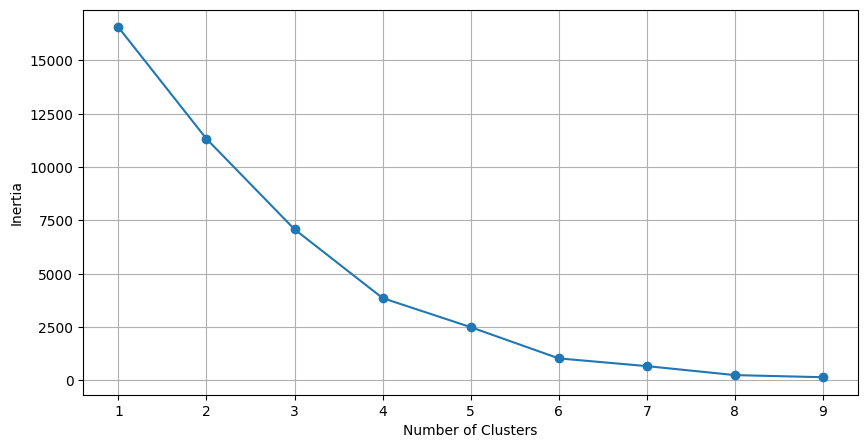

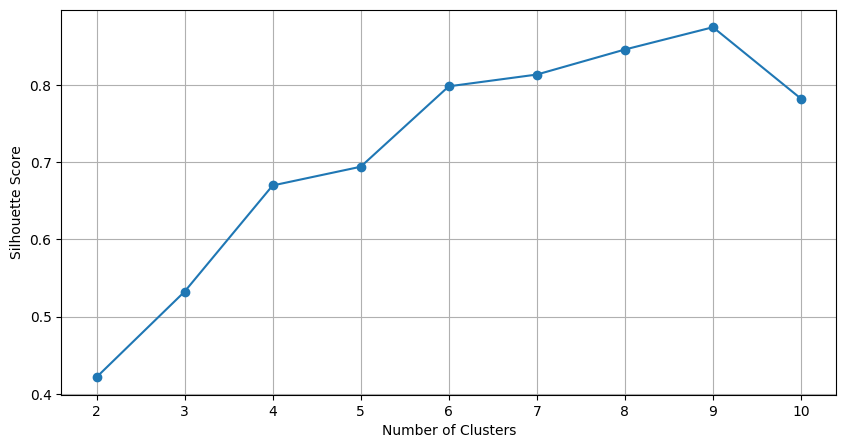

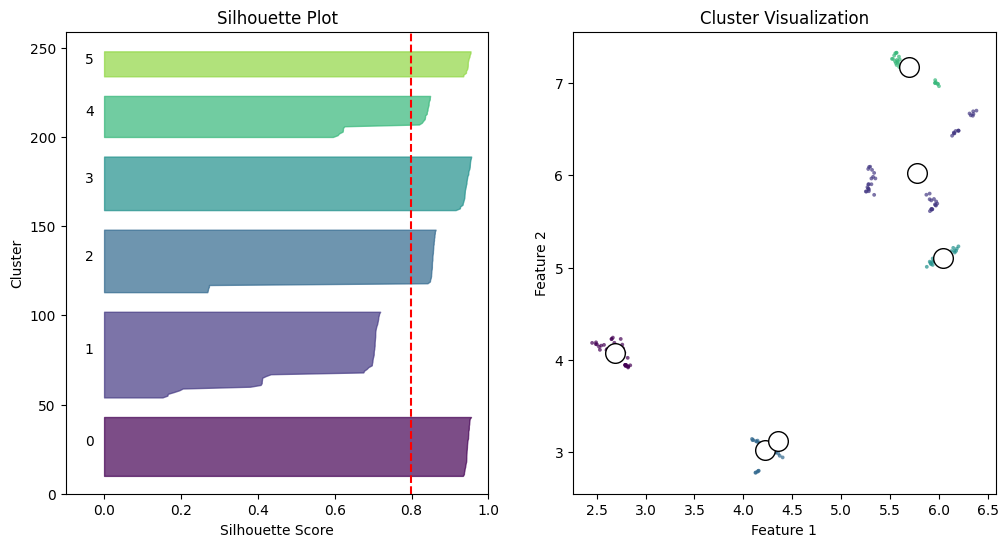

In [81]:
optimize_k_means_Elbow (X_umap, 10)
optimize_k_means_silhouette(X_umap, 10)
plot_silhouette_with_clusters(X_umap,6)

Applying K Means Clustering

In [82]:
kmeans = KMeans(n_clusters = 7, random_state = 23, n_init='auto')
kmeans.fit(X_umap)

KMeans(n_clusters=7, n_init='auto', random_state=23)

In order to visualize how clusters were corresponded, a umap fit is done but this time only with 2 components to have x-y axis

In [83]:
# getting labels
kmeans_labels = kmeans.predict(X_umap)

# Perform UMAP with 3 components
umap_plot_3d = UMAP(n_components=3, random_state=23)
X_plot_3d = umap_plot_3d.fit_transform(X_sc)
X_plot_kmeans_3d = np.c_[X_plot_3d, kmeans_labels]

# Create a scatter plot
fig = go.Figure()

# Add a scatter trace for each cluster
for cluster in np.unique(kmeans_labels):
    cluster_indices = np.where(kmeans_labels == cluster)
    fig.add_trace(go.Scatter3d(
        x=X_plot_kmeans_3d[cluster_indices, 0].flatten(),
        y=X_plot_kmeans_3d[cluster_indices, 1].flatten(),
        z=X_plot_kmeans_3d[cluster_indices, 2].flatten(),
        mode='markers',
        marker=dict(
            size=6,
            opacity=0.7,
            color=cluster,
            colorscale='Viridis'
        ),
        name=f'Cluster {cluster}'
    ))

# Set layout and show the plot
fig.update_layout(
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    title='UMAP 3D Plot with KMeans Labels',
    height = 800,
    width = 800
)

fig.show()



Defining a functions that plots the selected hyperparameters

In [84]:
def plot_final_result(X_matrix, X_scaled, y_actual, labels, algorithm_name):
    # Perform UMAP with 3 components
    umap_plot_3d = UMAP(n_components=3, random_state=23)
    X_plot = umap_plot_3d.fit_transform(X_scaled)
    X_plot = np.c_[X_plot_3d, labels]

    # Creating a dataframe with gaussian clusters and actual labels
    base_information = {'algorithm_labels': labels,
                        'actual_label_name': y_actual.to_numpy().ravel()}

    data_clusters = pd.DataFrame(base_information)

    # calculating silhouette score
    sil_score = silhouette_score(X_matrix, labels)
    # querying dataframe to verify most frequent label name per gaussian label
    algorithm_dict = data_clusters.groupby('algorithm_labels').agg({'actual_label_name': lambda x: x.mode().iloc[0]}).to_dict()['actual_label_name']
    data_clusters['predicted_label_name'] = data_clusters['algorithm_labels'].map(algorithm_dict) # predictions

    # Create a scatter plot
    fig = go.Figure()

    for cat_index, category in enumerate(np.unique(data_clusters['predicted_label_name'])):
        category_indices = np.where(data_clusters.predicted_label_name == category)
        fig.add_trace(go.Scatter3d(
                    x=X_plot[category_indices, 0].ravel(),
                    y=X_plot[category_indices, 1].ravel(),
                    z=X_plot[category_indices, 2].ravel(),
                    mode='markers',
                    marker=dict(
                        size=6,
                        opacity=0.7,
                        color=cat_index,
                        colorscale='Viridis'
                    ),
                    name=f'Category {category}'
                ))

    # Set layout and show the plot
    fig.update_layout(
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'
        ),
        title=f'UMAP 3D Plot with {algorithm_name} Labels, silhoutte score = {sil_score:.3f}',
        height = 800,
        width = 1000
        )

    fig.show()
    return data_clusters

Evaluating KMeans model with actual y labels

In [85]:
# getting labels
kmeans_labels = kmeans.predict(X_umap)
kmeans_result = plot_final_result(X_umap, X_sc, y, kmeans_labels, 'KMeans')

KeyError: "Column(s) ['label_name'] do not exist"

As it can be seen, KMeans model cannot predict the placenta target by having as a prediction the most frequent class at each kmeans component, afterall, there are other methods to be performed. Now it is time to evaluate recall, precision and f1 score using macro average.

In [ ]:
# getting actual values and predictions
y_actual = kmeans_result.label_name
y_pred = kmeans_result.predicted_label_name

# getting scores
recall_kmeans = recall_score(y_actual, y_pred, average = 'macro', zero_division = 0)
precision_kmeans = precision_score(y_actual, y_pred, average = 'macro', zero_division = 0)
f1_kmeans = f1_score(y_actual, y_pred, average = 'macro', zero_division = 0)

# Showing metrics
print(f"Recall score: {recall_kmeans:.4f}")
print(f"Precision score: {precision_kmeans:.4f}")
print(f"F1 score: {f1_kmeans:.4f}")

Recall score: 0.8198
Precision score: 0.7939
F1 score: 0.8036


# DBSCAN

Choosing the best epsilon (eps) through distances from a point to its nearest neighbor, with the breakpoint, we select the eps, and with the number of neighbors, we choose the min_samples

In [ ]:
# Create a dictionary to store the number of neighbors and distances
neighbors_dict = dict()

# declaring number of neighbors 
max_neighbors = 10

# Perform iterations
for n_neighbors in range(2, max_neighbors + 1):
    neigh = NearestNeighbors(n_neighbors = n_neighbors)
    neigh.fit(X_umap)

    # Distances would be in two columns, the first one representing the distance
    # of the point to itself, and the rest representing distances to its nearest neighbors
    distances, indices = neigh.kneighbors(X_umap)

    # Keep the maximum distance, i.e., the farthest neighbor, to determine which one can cover
    # the n neighbors
    max_distances = np.max(distances[:, 1:], axis=1)

    # Sort distances
    max_distances = np.sort(max_distances, axis=0)

    # Save distances in the dictionary
    neighbors_dict[n_neighbors] = max_distances

Create a plot for each neighbor and observe where the breakpoint occurs.

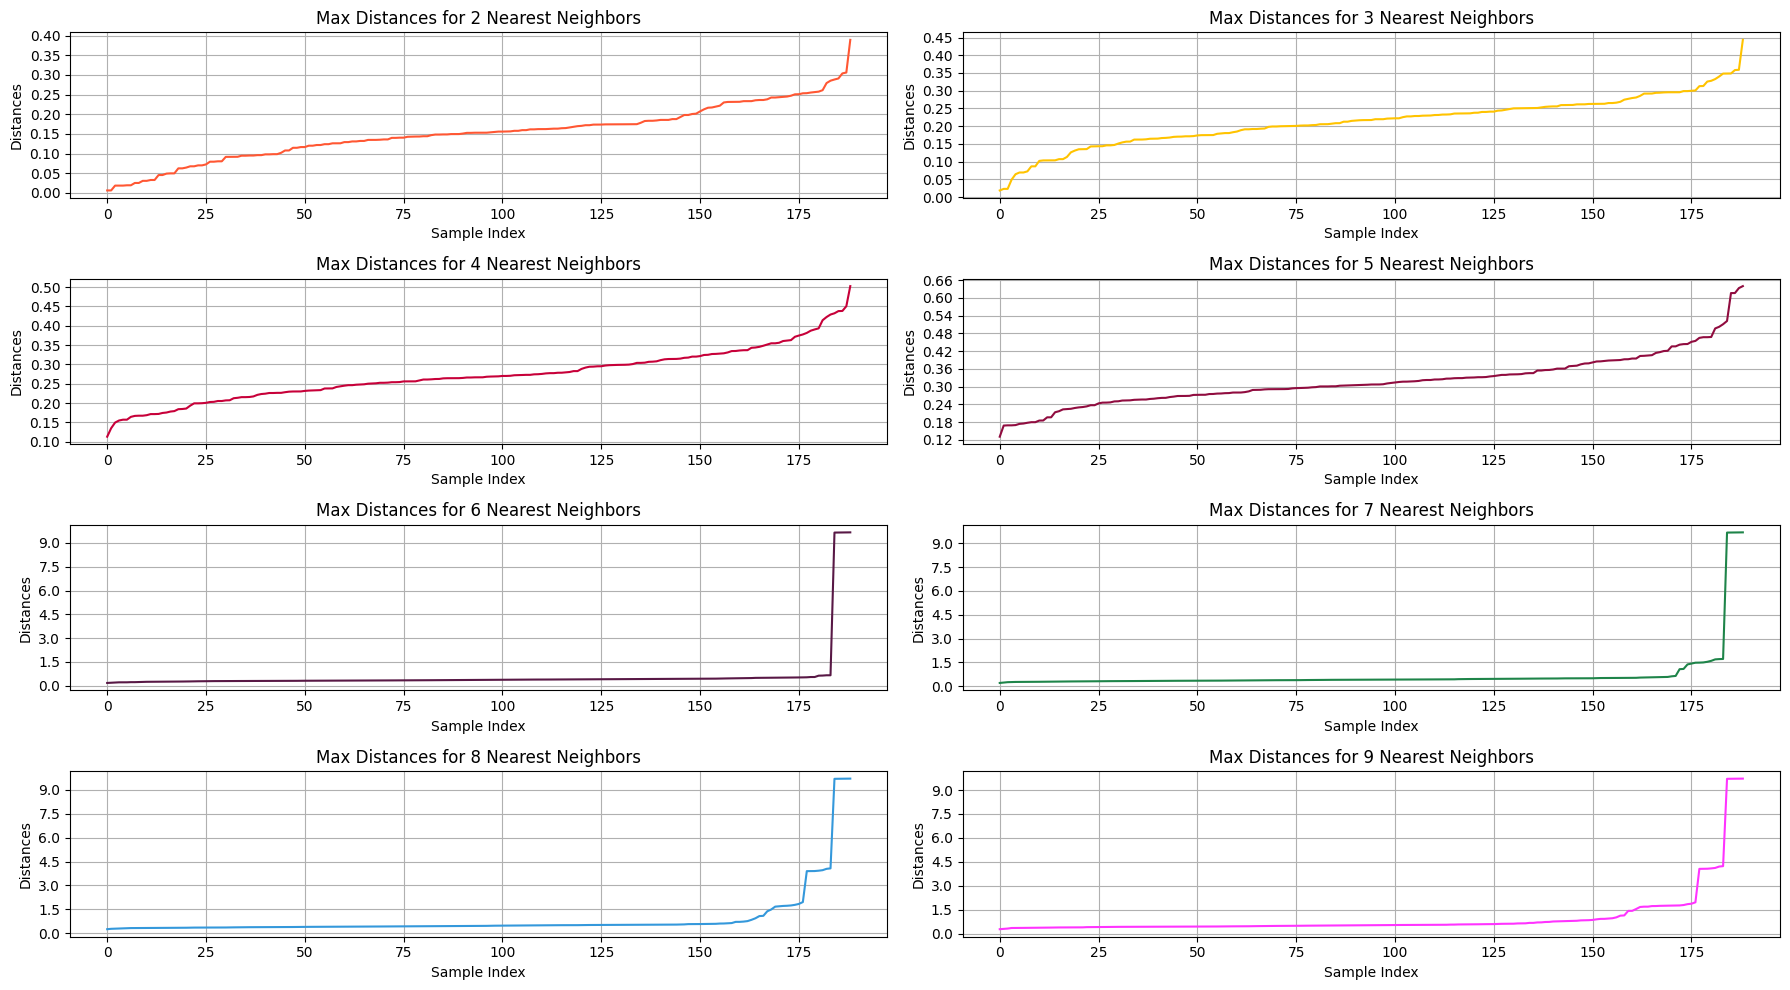

In [ ]:
fig, axis = plt.subplots(4, 2, figsize=(18, 10))
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
            "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]
plots_dict = dict(enumerate(range(2, 10)))
for position, n_neighbors in plots_dict.items():
    row = position // 2
    col = position % 2
    ax = axis[row, col]
    distances = neighbors_dict[n_neighbors]  # Asumiendo que neighbors_dict está definido en algún lugar
    ax.plot(distances, linestyle='-', color=colors[position])
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Distances')
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=10))
    ax.set_title(f'Max Distances for {n_neighbors} Nearest Neighbors')
    ax.grid()
plt.tight_layout()
plt.show()

For each plot, the following results are obtained through visual inspection (making equivalences of eps = distance at breakpoint and n_min_samples = n_neighbors)

* eps = 24, n_min_samples = 2
* eps = 23, n_min_samples = 3
* eps = 24, n_min_samples = 4
* eps = 25, n_min_samples = 5
* eps = 30, n_min_samples = 6
* eps = 30, n_min_samples = 7
* eps = 35, n_min_samples = 8
* eps = 30, n_min_samples = 9

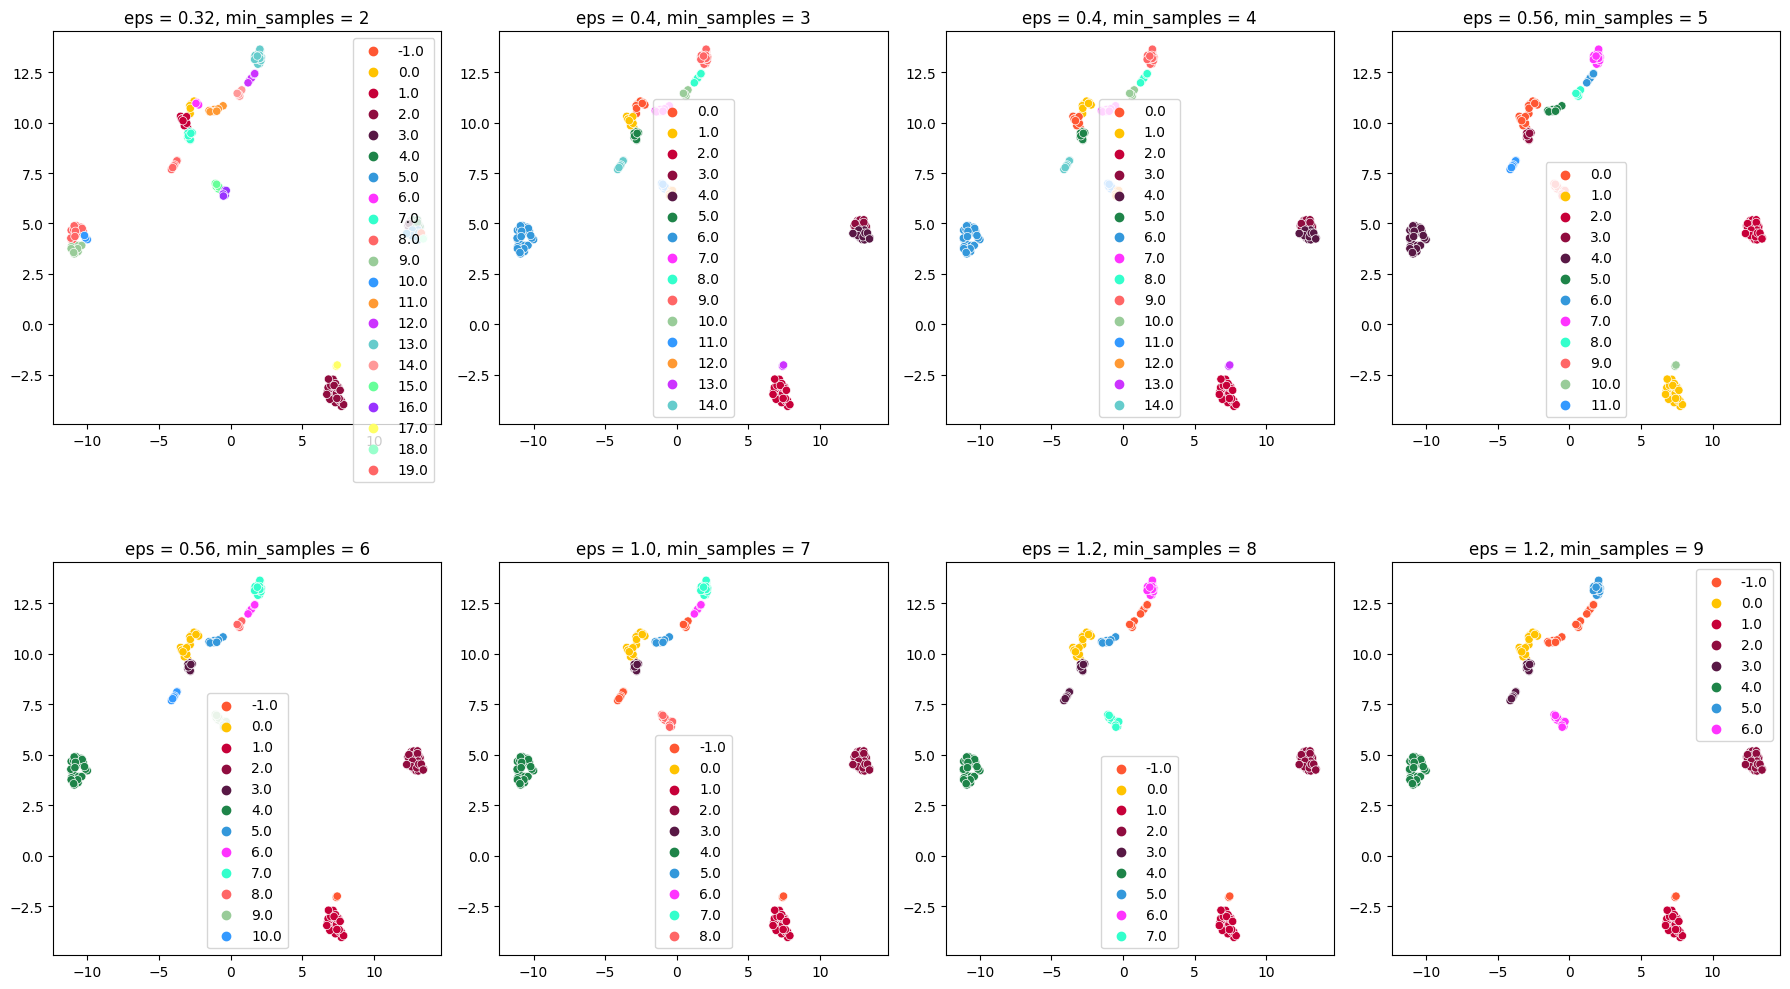

In [ ]:
# declaring UMAP instance to use to plot
umap_plot = UMAP(n_components = 2, random_state = 23)

# Creating the X_plot data set
X_plot = umap_plot.fit_transform(X_sc)
# Declare DBSCAN parameters (eps, n_min_samples)
dbscan_params = [(0.32, 2), (0.40, 3),
                 (0.40, 4), (0.56, 5),
                 (0.56, 6), (1.00, 7),
                 (1.20, 8), (1.2, 9)]

plot_order = list(range(9))

colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
          "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC",
          "#FF9999", "#66FF99", "#9933FF", "#FFFF66", "#99FFCC", "#FF6666", "#99CC99", "#FF9933",
          "#CC33FF", "#66CCCC", "#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845"]

# declaring UMAP instance to use to plot
umap_plot = UMAP(n_components = 2, random_state = 23)

# Creating the X_plot data set
X_plot = umap_plot.fit_transform(X_sc)

fig, axis = plt.subplots(2, 4, figsize=(18, 10))
for (eps, n_min_samples), order in zip(dbscan_params, plot_order):
    dbscan = DBSCAN(eps=eps, min_samples=n_min_samples)
    labels = dbscan.fit_predict(X_umap)
    n_labels = len(np.unique(labels))
    X_plot_dbscan = np.c_[X_plot, labels]
    # Visualize the results
    row = order // 4
    col = order % 4
    ax = axis[row, col]
    sns.scatterplot(x=X_plot_dbscan[:, 0], y=X_plot_dbscan[:, 1], hue=X_plot_dbscan[:, -1], palette=colors[:n_labels], ax=ax)
    ax.set_title(f'eps = {eps}, min_samples = {n_min_samples}')
plt.tight_layout()
plt.show()

As we can observe, there are several hyperparameters that perform well, a more detailed fitting based on these results is triggered

In [ ]:
list_eps = np.linspace(0.2, 2, 500)
list_min_samples = range(2, 10)
list_results = list()
for eps in list_eps:
    for min_samples in list_min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=int(min_samples))
        dbscan_labels = dbscan.fit_predict(X_umap)
        if len(set(dbscan_labels)) > 1:
            silhouette_avg = silhouette_score(X_umap, dbscan_labels, random_state=23)
            davies_bouldin_avg = davies_bouldin_score(X_umap, dbscan_labels)
            list_results.append((silhouette_avg,davies_bouldin_avg, eps,min_samples))

print('Maximum Silhouette Score:')
print(max(list_results, key = lambda x: x[0]))
print('Minimum Davies Bouldin Score:')
print(min(list_results, key = lambda x: x[1]))

Maximum Silhouette Score:
(0.897511, 0.1567758235619392, 0.5498997995991984, 2)
Minimum Davies Bouldin Score:
(0.897511, 0.1567758235619392, 0.5498997995991984, 2)


We are going to test these values and see what'd happen, as it can obe observed, the minimum davies bouldin score comes with the maximum silhouette score

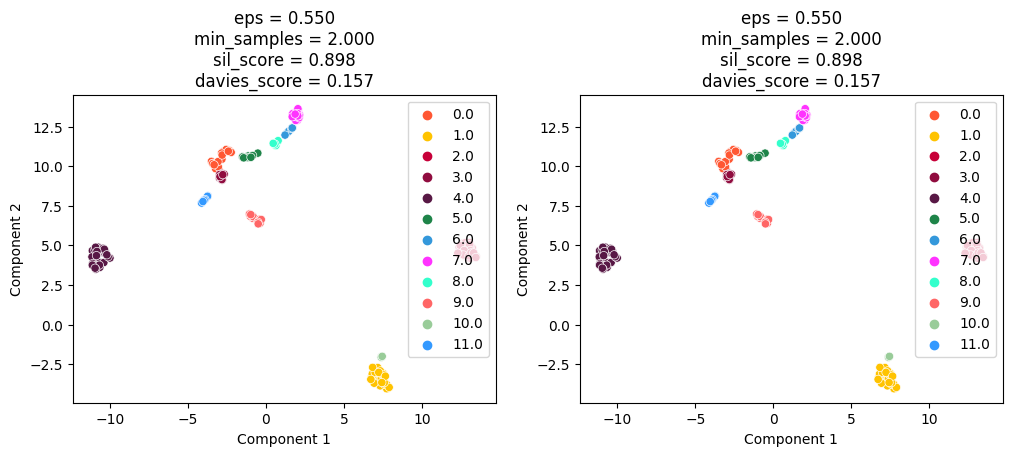

In [ ]:
fig, axis = plt.subplots(1, 2, figsize = (12, 4))

dbscan_results = [(max(list_results, key = lambda x: x[0])[2], max(list_results, key = lambda x: x[0])[3]),
                  (min(list_results, key = lambda x: x[1])[2], min(list_results, key = lambda x: x[1])[3])]

colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
            "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

for position, (eps, min_samples) in enumerate(dbscan_results):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_umap)
    silhouette_avg = silhouette_score(X_umap, dbscan_labels, random_state=23)
    davies_bouldin_avg = davies_bouldin_score(X_umap, dbscan_labels)

    # selection axis
    ax = axis[position]

    # ploting with sns
    n_unique_predicted = len(np.unique(dbscan_labels))

    X_plot_dbscan = np.c_[X_plot, dbscan_labels]      
    sns.scatterplot(x = X_plot_dbscan[:, 0], y = X_plot_dbscan[:, 1], hue = X_plot_dbscan[:, -1], palette = colors[:n_unique_predicted], ax = ax)
    ax.set_ylabel('Component 2')
    ax.set_xlabel('Component 1')
    ax.set_title(f'eps = {eps:.3f}\nmin_samples = {min_samples:.3f}\nsil_score = {silhouette_avg:.3f}\ndavies_score = {davies_bouldin_avg:.3f}')
    ax.legend(loc = 'upper right')
plt.show()

By visualizing the plots, it is observed that the best approach is the case where eps = 21.983967935871743 and min_samples = 2. Therefore, the final model is fitted with those hyperparameters and evaluated with the actual values.

In [ ]:
dbscan = DBSCAN(eps = dbscan_results[0][0], min_samples = dbscan_results[0][1])
dbscan_labels = dbscan.fit_predict(X_umap)
dbscan_result = plot_final_result(X_umap, X_sc, y, dbscan_labels, 'DBSCAN')

In [ ]:
# getting actual values and predictions
y_actual = dbscan_result.label_name
y_pred = dbscan_result.predicted_label_name

# getting scores
recall_dbscan = recall_score(y_actual, y_pred, average = 'macro', zero_division = 0)
precision_dbscan = precision_score(y_actual, y_pred, average = 'macro', zero_division = 0)
f1_dbscan = f1_score(y_actual, y_pred, average = 'macro', zero_division = 0)

# Showing metrics
print(f"Recall score: {recall_dbscan:.4f}")
print(f"Precision score: {precision_dbscan:.4f}")
print(f"F1 score: {f1_dbscan:.4f}")

NameError: name 'recall_score' is not defined

# Gaussian Mixture Model

It can be seen in the Hierchical picture, by cutting the Dendrogram at 106 Euclidian Distance, it is obtained 7 clusters which corresponds to the number of unique variable of "y" dataset. Now, a BIC score plot is made in order to verify these clusters

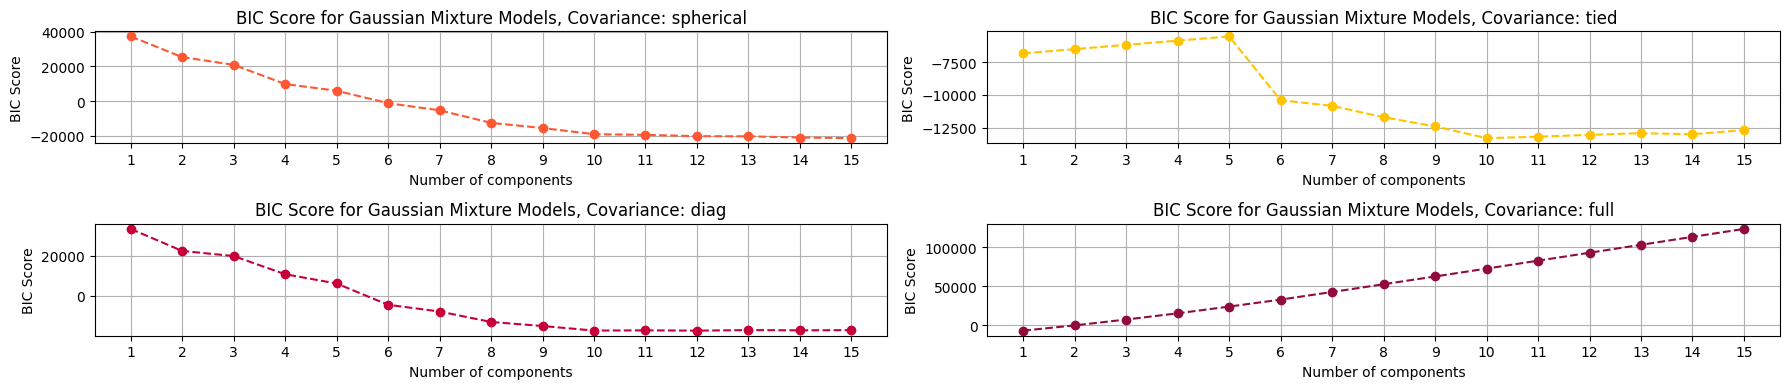

In [ ]:
# declaring a dictionary to store bics per covariance type
bic_per_type = dict()

# params to test
n_max_clusters = 15
covariance_types = ['spherical', 'tied', 'diag', 'full']

# iterating the number of clusters in a mixture gaussian instance
for covariance_type in covariance_types:
    # declaring an empty list which stores each inertia per number of clusters
    bic_scores = list()
    for n_clusters in range(1, n_max_clusters + 1):
        # declaring and fitting gaussian mixture model
        gaussian_model = GaussianMixture(n_components = n_clusters, covariance_type = covariance_type, 
                                        init_params = 'k-means++', random_state = 23, reg_covar = 1e-2)
        gaussian_model.fit(X_umap)
        bic_scores.append(gaussian_model.bic(X_umap))
    # storing bic types
    bic_per_type[covariance_type] = bic_scores

# defining positions for covariances types and colors
plots_dict = dict(enumerate(covariance_types))
gauss_colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F"]

# getting the number of components per covariance type which contains the lowest bic
n_components_bic = {key: (min(enumerate(bic_per_type[key]), key = lambda x: x[1])[0] + 1, min(bic_per_type[key]))
                                for key in covariance_types}

# plotting BIC Scores
fig, axis = plt.subplots(2, 2, figsize = (18,4))

for key, data in plots_dict.items():
    row = key // 2
    col = key % 2
    ax = axis[row, col]
    ax.plot(bic_per_type[data], marker = 'o', linestyle = '--', color = gauss_colors[key])
    ax.set_xlabel('Number of components')
    ax.set_xticks(range(0, n_max_clusters), range(1, n_max_clusters + 1))
    ax.set_ylabel('BIC Score')
    ax.set_title(f'BIC Score for Gaussian Mixture Models, Covariance: {data}')
    ax.grid(True)

plt.tight_layout()
plt.show()

Another way to test the n_components performance is by selecting the best silhouette score, the following cells shows the evaluation in terms of it

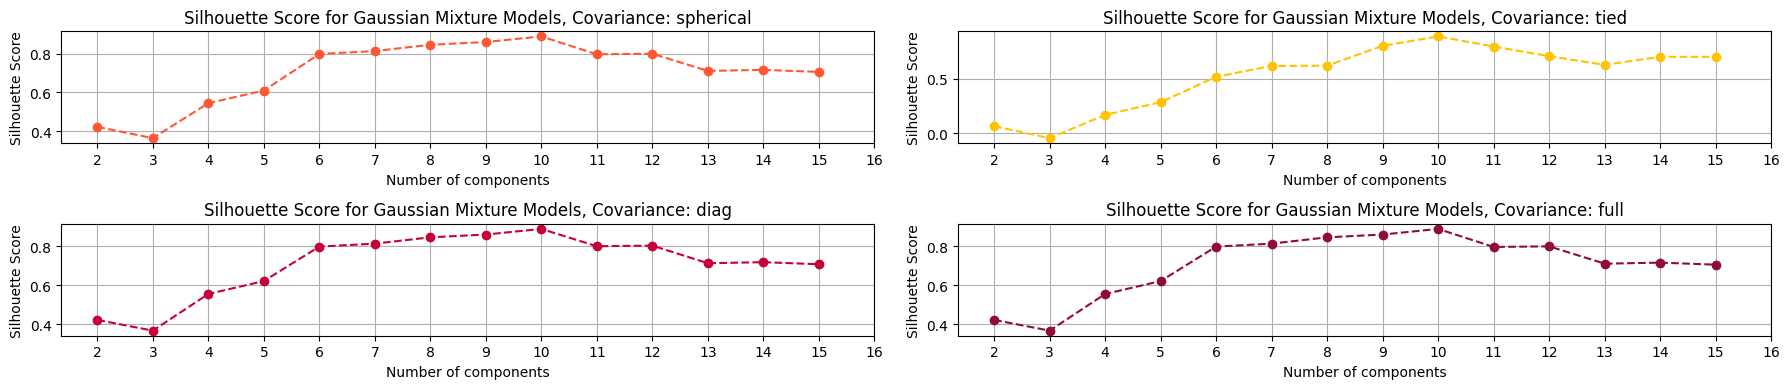

In [ ]:
# declaring a dictionary to store bics per covariance type
silhouette_per_type = dict()

# params to test
n_max_clusters = 15
covariance_types = ['spherical', 'tied', 'diag', 'full']

# iterating the number of clusters in a mixture gaussian instance
for covariance_type in covariance_types:
    # declaring an empty list which stores each inertia per number of clusters
    silhouette_scores = list()
    for n_clusters in range(2, n_max_clusters + 1):
        # declaring and fitting gaussian mixture model
        gaussian_model = GaussianMixture(n_components = n_clusters, covariance_type = covariance_type, 
                                        init_params = 'k-means++', random_state = 23, reg_covar = 1e-2)
        gaussian_model.fit(X_umap)
        silhouette_scores.append(silhouette_score(X_umap, gaussian_model.predict(X_umap)))
    # storing bic types
    silhouette_per_type[covariance_type] = silhouette_scores

# defining positions for covariances types and colors
plots_dict = dict(enumerate(covariance_types))
gauss_colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F"]

# getting the number of components per covariance type which contains the highest silhouette score
n_components_sil = {key: (max(enumerate(silhouette_per_type[key]), key = lambda x: x[1])[0] + 2, max(silhouette_per_type[key]))
                                for key in covariance_types}

# plotting BIC Scores
fig, axis = plt.subplots(2, 2, figsize = (18,4))

for key, data in plots_dict.items():
    row = key // 2
    col = key % 2
    ax = axis[row, col]
    ax.plot(silhouette_per_type[data], marker = 'o', linestyle = '--', color = gauss_colors[key])
    ax.set_xlabel('Number of components')
    ax.set_xticks(range(0, n_max_clusters), range(2, n_max_clusters + 2))
    ax.set_ylabel('Silhouette Score')
    ax.set_title(f'Silhouette Score for Gaussian Mixture Models, Covariance: {data}')
    ax.grid(True)

plt.tight_layout()
plt.show()

Showing the lowest BIC and the highest Silhouette score per covariance type and select the minimum , maximum one

In [ ]:
bic_summary = pd.DataFrame(n_components_bic).T.rename(columns = {0: 'n_components_bic', 1: 'bic_score'})
sil_summary = pd.DataFrame(n_components_sil).T.rename(columns = {0: 'n_components_sil', 1: 'sil_score'})
result_summary = pd.concat([bic_summary, sil_summary], axis = 1)
display(result_summary)

,n_components_bic,bic_score,n_components_sil,sil_score
spherical,15.0,-21266.117111,10.0,0.889028
tied,10.0,-13314.642576,10.0,0.889028
diag,12.0,-17369.296365,10.0,0.889028
full,1.0,-6806.599102,10.0,0.889028


As it can be observed in the plot, the lowest BIC score corresponds to a 7th-cluster-full-gaussian mixture model and the highest silhoutte to a 9th-cluster-spherical-gaussian one, this makes sense regarding the previous hierarchical plot, which showed below the threshold that there were more divisions that could have been made by decreasing this value. Now, in order to select one of them, it is compared both metrics for both cases, then it is selected one

In [ ]:
# declaring selected n_components and covariance types
n_components_list = [int(result_summary.loc[result_summary.bic_score == result_summary.bic_score.min(), 'n_components_bic'][0]),
                     int(result_summary.loc[result_summary.sil_score == result_summary.sil_score.max(), 'n_components_sil'][0])]
covariance_types_list = [result_summary.loc[result_summary.bic_score == result_summary.bic_score.min()].index[0],
                         result_summary.loc[result_summary.sil_score == result_summary.sil_score.max()].index[0]]

# empty dictionary to store bic and silhouette scores
bic_sil_list = list()
# iterating with the same gaussian attributes
for covariance_type, n_components in zip(covariance_types_list, n_components_list):
    # declaring and fitting gaussian mixture model
    gaussian_model = GaussianMixture(n_components = n_components, covariance_type = covariance_type, 
                                    init_params = 'k-means++', random_state = 23, reg_covar = 1e-2)
    # fitting model
    gaussian_model.fit(X_umap)

    # storing metrics
    bic_sil_score = dict()
    bic_sil_score['covariance_type'] = covariance_type
    bic_sil_score['n_components'] = n_components
    bic_sil_score['bic_score'] = gaussian_model.bic(X_umap)
    bic_sil_score['sil_score'] = silhouette_score(X_umap, gaussian_model.predict(X_umap))
    bic_sil_list.append(bic_sil_score)

As it can be seen , $full$ with 7 components has a lower bic_score and a lower sil_score in contrast, and $spherical$ with 9 components has a greater bic_score and a greater sil_score. Thus, both are selected to test the incoming labels

In [ ]:
bic_sil_tbl = pd.DataFrame(bic_sil_list)
display(bic_sil_tbl)

,covariance_type,n_components,bic_score,sil_score
0,spherical,15,-21266.117111,0.705582
1,spherical,10,-18985.961341,0.889028


Fitting both models to finally evaluate them 

In [ ]:
# declaring selected n_components and covariance types
n_components_list = [int(result_summary.loc[result_summary.bic_score == result_summary.bic_score.min(), 'n_components_bic'][0]),
                     int(result_summary.loc[result_summary.sil_score == result_summary.sil_score.max(), 'n_components_sil'][0])]
covariance_types_list = [result_summary.loc[result_summary.bic_score == result_summary.bic_score.min()].index[0],
                         result_summary.loc[result_summary.sil_score == result_summary.sil_score.max()].index[0]]

# store both models in a list
gaussian_models = list()

# iterating across components
for covariance_type, n_components in zip(covariance_types_list, n_components_list):
    # declaring and fitting gaussian mixture model
    gaussian_model = GaussianMixture(n_components = n_components, covariance_type = covariance_type, 
                                    init_params = 'k-means++', random_state = 23, reg_covar = 1e-2)
    # fitting model
    gaussian_model.fit(X_umap)

    # storing model
    gaussian_models.append(gaussian_model)

Now it has been fitted, predictions need to be performed to get the labels the model has grouped

In [ ]:
# getting labels
gaussian_labels = [gaussian_model.predict(X_umap).astype(int) for gaussian_model in gaussian_models]

In order to visualize how clusters were corresponded, another pca fit is done but this time only with 2 components to have x-y axis

In [ ]:
# Declaring umap instance to use for plotting
umap_plot = UMAP(n_components=3, random_state=23)

# Creating the X_plot dataset
X_plot = umap_plot.fit_transform(X_sc)

# Plotting with Plotly
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
          "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

for j in range(2):
    model = gaussian_models[j]
    X_plot_gauss = np.c_[X_plot, gaussian_labels[j]]
    n_components = len(np.unique(gaussian_labels[j]))
    
    for category in np.unique(gaussian_labels[j]):
        category_indices = (gaussian_labels[j] == category)
        scatter = go.Scatter3d(x=X_plot_gauss[category_indices, 0], 
                               y=X_plot_gauss[category_indices, 1], 
                               z=X_plot_gauss[category_indices, 2],
                               mode='markers', 
                               marker=dict(color=colors[category], size=5),
                               name=f'Category {category}',
                               legendgroup=f'Category {category}')

        fig.add_trace(scatter, row=1, col=j + 1)

titles = [f'n = {gaussian_models[0].n_components}, covariance = {gaussian_models[0].covariance_type}',
          f'n = {gaussian_models[1].n_components}, covariance = {gaussian_models[1].covariance_type}']

legend_1 = go.layout.Annotation(x=0.5, y=1.15, xref="paper", yref="paper", text=titles[0], showarrow=False, font=dict(size=15))
legend_2 = go.layout.Annotation(x=1.5, y=1.15, xref="paper", yref="paper", text=titles[1], showarrow=False, font=dict(size=15))

# Configure the layout of the plot
fig.update_layout(scene1=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  scene2=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  width=1500,
                  height=700,
                  annotations=[
                      dict(
                          showarrow=False,
                          text=titles[0],
                          xref='paper', yref='paper',
                          x=0, y=1.05,
                          font=dict(size=15)
                      ),
                      dict(
                          showarrow=False,
                          text=titles[1],
                          xref='paper', yref='paper',
                          x=0.5, y=1.05,
                          font=dict(size=15)
                      )
                  ])

fig.show()


Then it is compared to the actual "y" targets, as first step, a encoding transformation has to be performed before the comparison

In [ ]:
# changing unique values for numeric ones
y_label = np.zeros((len(y), 1))
target_dict = dict()
for label, tissue_type in enumerate(np.unique(y)):
    y_label = np.where(y == tissue_type, label, y_label)
    target_dict[label] = tissue_type

y_label = y_label.ravel().astype(int)

# Creating the X_plot dataset for the third subplot
X_plot_real = np.c_[X_plot, y_label]

colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
          "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# first two subplots
for j in range(2):
    model = gaussian_models[j]
    X_plot_gauss = np.c_[X_plot, gaussian_labels[j]]
    n_components = len(np.unique(gaussian_labels[j]))
    
    for category in np.unique(gaussian_labels[j]):
        category_indices = (gaussian_labels[j] == category)
        scatter = go.Scatter3d(x=X_plot_gauss[category_indices, 0], 
                               y=X_plot_gauss[category_indices, 1], 
                               z=X_plot_gauss[category_indices, 2],
                               mode='markers', 
                               marker=dict(color=colors[category], size=5),
                               name=f'Category {category}',
                               legendgroup=f'Category {category}')

        fig.add_trace(scatter, row=1, col=j + 1)

# third subplot
for category in np.unique(y_label):
    category_indices = (y_label == category)
    scatter = go.Scatter3d(x=X_plot_real[category_indices, 0], 
                           y=X_plot_real[category_indices, 1], 
                           z=X_plot_real[category_indices, 2],
                           mode='markers', 
                           marker=dict(color=colors[category], size=5),
                           name=f'Category {category}',
                           legendgroup=f'Category {category}')

    fig.add_trace(scatter, row=1, col=3)

titles = [f'n = {gaussian_models[0].n_components}, covariance = {gaussian_models[0].covariance_type}',
          f'n = {gaussian_models[1].n_components}, covariance = {gaussian_models[1].covariance_type}',
          'umap plot using Actual labels']

# Configure the layout of the plot
fig.update_layout(scene1=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  scene2=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  scene3=dict(xaxis_title='Component 1', yaxis_title='Component 2', zaxis_title='Component 3'),
                  width=2000,
                  height=700,
                  annotations=[
                      dict(
                          showarrow=False,
                          text=titles[0],
                          xref='paper', yref='paper',
                          x=0, y=1.05,
                          font=dict(size=15)
                      ),
                      dict(
                          showarrow=False,
                          text=titles[1],
                          xref='paper', yref='paper',
                          x=0.5, y=1.05,
                          font=dict(size=15)
                      ),
                      dict(
                          showarrow=False,
                          text=titles[2],
                          xref='paper', yref='paper',
                          x=1, y=1.05,
                          font=dict(size=15)
                      )
                  ])

fig.show()


By looking at the plots, it can be appreciated some differences, and, based on the fact that class numbers have nothing to do with the gaussian labels inasmuch as the second ones were assigned during the fitting process without having actual labels information. Thus, a check cluster task is performed to visualize the most frequent actual label in each gaussian cluster

In [ ]:
gaussian_results = list()
title_gmm = titles[:2]
for gaussian_label, string in zip(gaussian_labels, title_gmm):
    gaussian_results.append(plot_final_result(X_umap, X_sc, y, gaussian_label, string))

As it can be seen, the best silhoutte score is obtained by the second gaussian, so this one is chosen

# Results Comparison

Now We compare the best result per each fitted algorithm by using cross validation an silhouette score

In [ ]:
def purity_score(y_true, y_pred):
    contingency_matrix = Counter(list(zip(y_true, y_pred)))
    purity = 0
    for cluster_label in set(y_pred):
        cluster = [true_label for true_label, pred_label in contingency_matrix.keys() if pred_label == cluster_label]
        most_common_true_label = max(cluster, key=cluster.count)
        purity += cluster.count(most_common_true_label)
    purity /= len(y_pred)
    return purity

In [ ]:
# getting gaussian results
gaussian_result = gaussian_results[1]

# algorithm names
result_names = ['KMeans', 'DBSCAN', 'GMM']
# getting selected scores: silhouette_score, davies_bouldin_score, adjusted_rand_score, purity_score, entropy

# pre dataframe
pre_dataframe = dict()

for result_name, result in zip(result_names, [kmeans_result, dbscan_result, gaussian_result]):
    sil_score = silhouette_score(X_umap, result.algorithm_labels)
    davies_score = davies_bouldin_score(X_umap, result.algorithm_labels)
    ad_rand_score = adjusted_rand_score(result.actual_label_name, result.predicted_label_name)
    entropy_score = entropy(result.predicted_label_name)
    pur_score = accuracy_score(result.actual_label_name, result.predicted_label_name)
    pre_dataframe[result_name] = [sil_score, davies_score, ad_rand_score, entropy_score, pur_score]

# full dataframe
collapsed_data = pd.DataFrame(pre_dataframe, 
                              index = ['Silhouette Score', 'Davies Bouldin Score', 'Adjusted Rand Index Score', 'Entropy', 'Purity'])

display(collapsed_data)

AttributeError: 'DataFrame' object has no attribute 'actual_label_name'